In [ ]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
import math
import cv2


# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops
print(tf.__version__)

if StrictVersion(tf.__version__) < StrictVersion('1.9.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.9.* or later!')


1.13.1


## Env setup

In [ ]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [ ]:
from utils import label_map_util
from utils import visualization_utils as vis_util

/home/jaisakthi/JS/imageclef_coral2019/Documents/TensorFlow/models/research/object_detection/utils/visualization_utils.py:26: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/jaisakthi/anaconda3/envs/deep_learning/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/jaisakthi/anaconda3/envs/deep_learning/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jaisakthi/anaconda3/envs/deep_learning/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/jaisakthi/anaconda3/envs/deep_learning/lib/python3.6/site-packages/traitlets/config/application.py", line 658, i

# Model preparation

In [ ]:
# What model to download.
#MODEL_NAME ='/home/vit/JS/imageclef_coral2019/Documents/TensorFlow/workspace/training_demo/pre-trained-model_ssd_inception_v2'
MODEL_NAME = 'res_faster_rcnn_resnet101_coco_aug' # add graph name
#MODEL_NAME = '/home/vit/tmp/models/research/object_detection/res_faster_rcnn_inception_resnet_v2_atrous' # add graph name

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('training_faster_rcnn_resnet101_coco_aug', 'object-detection.pbtxt')
#PATH_TO_LABELS = os.path.join('/home/vit/JS/imageclef_coral2019/Documents/TensorFlow/workspace/training_demo/annotations', 'label_map.pbtxt')
NUM_CLASSES=13

In [ ]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [ ]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [ ]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [ ]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '/home/jaisakthi/JS/imageclef_coral2019/Documents/TensorFlow/workspace/training_demo/images/test/' #'test_images'
TEST_IMAGE_IDS = next(os.walk(PATH_TO_TEST_IMAGES_DIR))[2]
TEST_IMAGE_PATHS = list()
for i in (TEST_IMAGE_IDS):
    f = PATH_TO_TEST_IMAGES_DIR + i
    TEST_IMAGE_PATHS.append(f)
#TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 2) ]
print(len(TEST_IMAGE_IDS))
#TEST_IMAGE_PATHS = "/home/jaisakthi/Desktop/test/"
# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

205


In [ ]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [ ]:
def write_result(im_width, im_height, image_id, output_dict, count, img_path):
    import csv
    map = ["c_hard_coral_branching","c_soft_coral","c_hard_coral_boulder","c_sponge_barrel","c_sponge","c_hard_coral_encrusting","c_hard_coral_submassive","c_algae_macro_or_leaves","c_hard_coral_mushroom","c_hard_coral_foliose","c_fire_coral_millepora","c_soft_coral_gorgonian","c_hard_coral_table",]
    row=str( image_id)+";"
    img = cv2.imread(img_path)
    for x,y in enumerate(map):
        x=x+1
        #print("x",x)
        initial =0
        for a,b in enumerate(output_dict['detection_classes']):

            if x==b:

              if output_dict['detection_scores'][a]>=0.5:
                #print("ture")
                coordinate = output_dict['detection_boxes'][a].tolist()
                '''coordinate[0] = math.ceil(coordinate[0]* 4032)
                coordinate[1] = math.ceil(coordinate[1]* 4032)
                coordinate[2] = math.ceil(coordinate[2]* 3024)
                coordinate[3] = math.ceil(coordinate[3]* 3024)'''
                #cv2.rectangle(img, (coordinate[2], coordinate[0]), (coordinate[3], coordinate[1]), (255,0,0), 2)
                 #ymin, xmin, ymax, xmax
                #cv2.line(img,(0,0),(511,511),(255,0,0),5)
                 #draw.line([(left, top), (left, bottom), (right, bottom),
             #(right, top), (left, top)], width=thickness, fill=color)
                if initial ==0:
                  #print("initiate")
                  row =row+str(y)+" "+str(output_dict['detection_scores'][a])+":"+str(coordinate[0])+"+"+str(coordinate[1])+"+"+str(coordinate[2])+"+"+str(coordinate[3])+","
                  initial =initial +1
                  count = count+1
                  #print("ini",initial)
                else:
                  row =row+str(output_dict['detection_scores'][a])+":"+str(coordinate[0])+"+"+str(coordinate[1])+"+"+str(coordinate[2])+"+"+str(coordinate[3])+","
                  initial =initial +1
                  count = count + 1
                  #print("init2",initial)
        #print("initial val",initial)
        if initial ==1:
          row=row.split(",")[0]+";"
        row = list(row)
        row[-1]=";"
        row="".join(row)


#   for x,y in enumerate(output_dict['detection_scores']):
#     if y >0.5:
#       coordinate = output_dict['detection_boxes'][x].tolist()
#       print(coordinate)
#       row =row+str(map[output_dict['detection_classes'][x]])+" "+str(y)+":"+str(coordinate[0])+"+"+str(coordinate[1])+"+"+str(coordinate[2])+"+"+str(coordinate[3])+";"
      #Row=[image_id,map[output_dict['detection_classes'][x]],y,]
#    print(row)


    filename = "tmp.txt"#'ouput_ouput_faster_rcnn_inception_resnet_v2_atrous1.txt'

    if os.path.exists(filename):
        append_write = 'a' # append if already exists
    else:
        append_write = 'w' # make a new file if not
    highscore = open(filename,append_write)
    highscore.write(row+"\n")
    highscore.close()
    return True, count


In [ ]:
from collections import defaultdict
def write_result_new(image_id, output_dict, count, img_path,im_width,im_height):
    print(im_width,im_height)
    img = cv2.imread(image_path)
    image_id = image_id.split(".")
    row=str(image_id[0])+";"
    res = defaultdict(list)
    s=[]
    #score = out_dict['detection_scores']
    i=0

    for index,value in enumerate(output_dict['detection_classes']):
        #print(output_dict['detection_scores'][0])
        if output_dict['detection_scores'][index] > 0.2:
            class_name = category_index.get(value).get('name')
            score = output_dict['detection_scores'][index]
            boxes=output_dict['detection_boxes'][index]
            ymin = boxes[0]*im_height
            xmin = boxes[1]*im_width
            ymax = boxes[2]*im_height
            xmax = boxes[3]*im_width
            w = xmax-xmin
            h = ymax-ymin
            res[class_name].append(str(score)+":"+str(w)+"X"+str(h)+"+"+str(xmin)+"+"+str(ymin))
            x = boxes[1] * im_width
            y = boxes[0] * im_height
            right = boxes[3] * im_width
            bottom = boxes[2] * im_height
            row = row + res
            #cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 255, 0), thickness=10)
    row = row[:-1]
    print(row)
    #print(str(res))

    ''' plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

    filename = "tmp.txt"#'ouput_ouput_faster_rcnn_inception_resnet_v2_atrous1.txt'

    if os.path.exists(filename):
        append_write = 'a' # append if already exists
    else:
        append_write = 'w' # make a new file if not
    highscore = open(filename,append_write)
    highscore.write(row+"\n")
    highscore.close()'''




/home/jaisakthi/JS/imageclef_coral2019/Documents/TensorFlow/workspace/training_demo/images/test/2018_0712_073341_034.JPG
4032 3024
defaultdict(<class 'list'>, {'c_soft_coral': ['0.9999988:780.1934909820557X630.8766489028931+1248.6432781219482+2123.3732986450195', '0.9999839:912.1117572784424X750.4944840967655+1572.5098628997803+24.141259521245956', '0.9999218:119.18111228942871X142.02518820762634+372.5975031852722+664.7852704524994'], 'c_sponge': ['0.99998045:368.79876136779785X236.58660650253296+839.6956672668457+1097.0807104110718', '0.48242036:320.78993225097656X127.2144570350647+3648.0870208740234+1328.86740732193', '0.23685709:418.79676818847656X313.16210746765137+1312.4345512390137+884.1277556419373'], 'c_hard_coral_boulder': ['0.9838186:187.92838668823242X323.95081901550293+2738.217384338379+1918.879846572876'], 'c_hard_coral_branching': ['0.9336417:409.3341751098633X357.4898943901062+1321.0844821929932+850.1473517417908'], 'c_hard_coral_mushroom': ['0.92660564:178.5724983215332

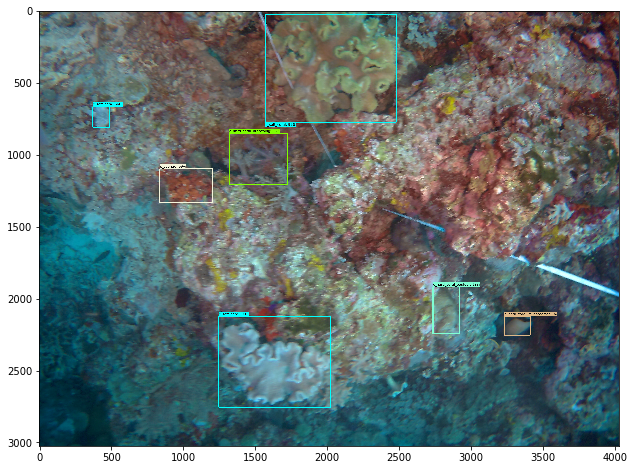

In [ ]:
c=1
#for image_path in TEST_IMAGE_PATHS:
for i in range(135, 136):
  image_path = TEST_IMAGE_PATHS[i]
  image = Image.open(image_path)
  (w, h) = image.size
  image_id = image_path.split("/")[-1]
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  print(image_path)
  #img = cv2.imread(image_path)

  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  #x, c = write_result(w, h, image_id,output_dict,c,image_path)
  write_result_new(image_id,output_dict,c,image_path,w,h)
  #display_opencv_image(image_path,detection_graph)
  #print(output_dict)
  #print(output_dict['num_detections'])
  #print(output_dict['detection_scores'])
  #print(output_dict['detection_classes'])
  #print(output_dict['detection_boxes'])
  #print([category_index.get(i).get('name') for i in output_dict['detection_classes']])
  #scores = output_dict['detection_scores']
  #data = [category_index.get(value) for index,value in enumerate(output_dict['detection_classes']) if scores[0,index] > 0.9]
  #print(GetClassName(data))
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)
#print(c)